# Camera Calibration

In [12]:
import numpy as np
import glob
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

NX = 9
NY = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((NX*NY, 3), np.float32)
objp[:,:2] = np.mgrid[0:NX, 0:NY].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
image_files = glob.glob('camera_cal/*.jpg')

for fname in image_files:
    im = mpimg.imread(fname)
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

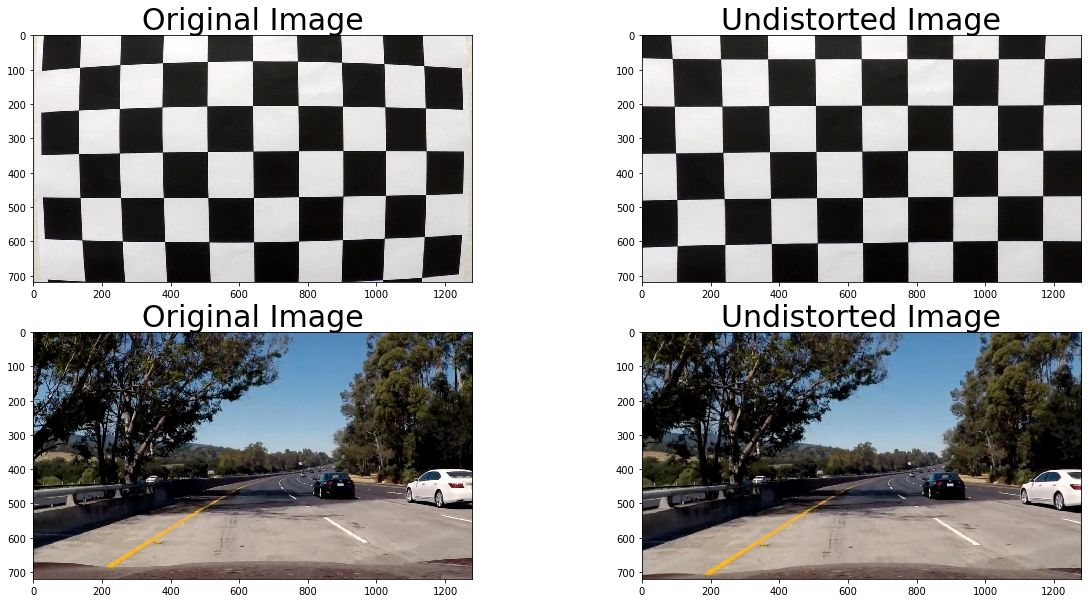

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

test_chessboard = mpimg.imread('camera_cal/calibration1.jpg')
test_image = mpimg.imread('test_images/test5.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                   (test_image.shape[1], test_image.shape[0]), None, None)

def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

undist_chessboard = undistort(test_chessboard)
undist = undistort(test_image)

f, axarr = plt.subplots(2, 2, figsize=(20,10))
axarr[0][0].imshow(test_chessboard)
axarr[0][0].set_title('Original Image', fontsize=30)
axarr[0][1].imshow(undist_chessboard)
axarr[0][1].set_title('Undistorted Image', fontsize=30)
axarr[1][0].imshow(test_image)
axarr[1][0].set_title('Original Image', fontsize=30)
axarr[1][1].imshow(undist)
axarr[1][1].set_title('Undistorted Image', fontsize=30)

# Gradient & Color Threshold

## Gradient Threshold

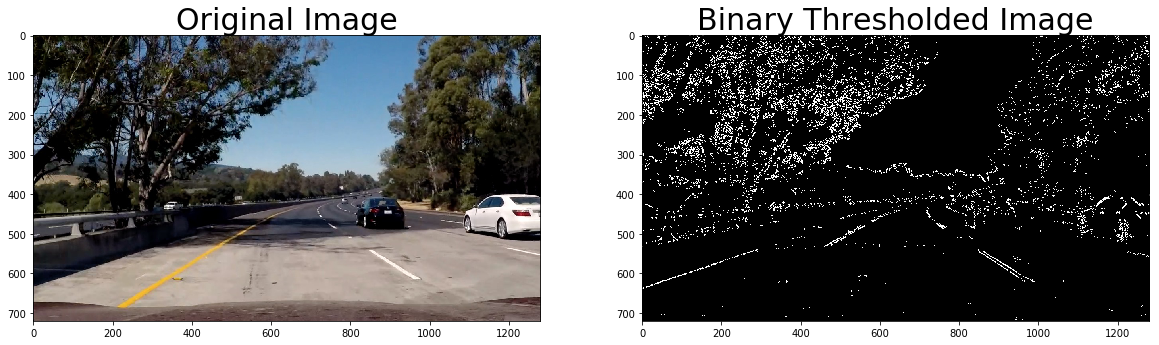

In [14]:
%matplotlib inline

def gradient_threshold(image):
    
    def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        # Return the result
        return binary_output
    
    def mag_thresh(img, ksize=3, mag_thresh=(0, 255)):
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
        # Return the binary image
        return binary_output

    def dir_threshold(img, ksize=3, thresh=(0, np.pi/2)):
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output = np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
        # Return the binary image
        return binary_output
    
    ksize = 3
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    gradx = abs_sobel_thresh(gray, orient='x', thresh=(20, 110))
    grady = abs_sobel_thresh(gray, orient='y', thresh=(20, 110))
    mag_binary = mag_thresh(gray, mag_thresh=(30, 200))
    dir_binary = dir_threshold(gray, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined
    
test_image = mpimg.imread('test_images/test5.jpg')
binary_output = gradient_threshold(undistort(test_image))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Binary Thresholded Image', fontsize=30)

## Color Threshold

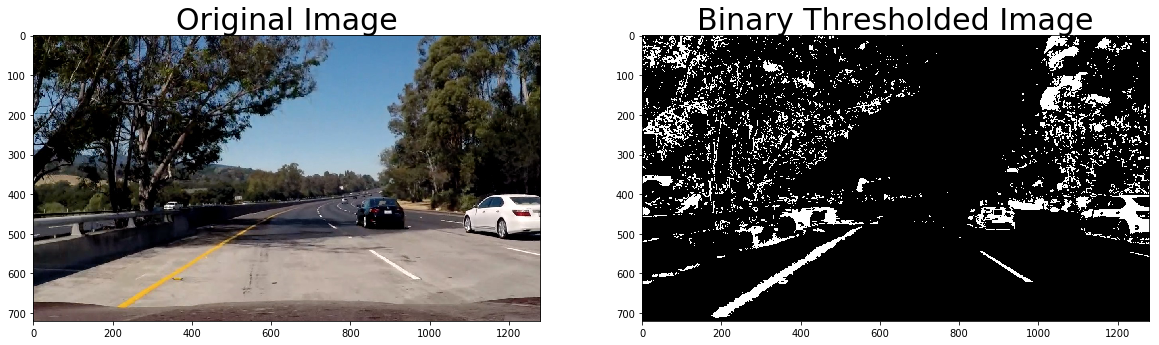

In [15]:
def color_threshold(image):
    s_thresh = (170, 255)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) 
    s_channel = hls[:,:,2]
    
    l_thresh = (225, 255)
    luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    
    b_thresh = (155, 200)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    b_channel = luv[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])) |
                  ((l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])) |
                  ((b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1]))] = 1
    return binary_output

test_image = mpimg.imread('test_images/test5.jpg')
binary_output = color_threshold(undistort(test_image))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Binary Thresholded Image', fontsize=30)

## Combined Threshold

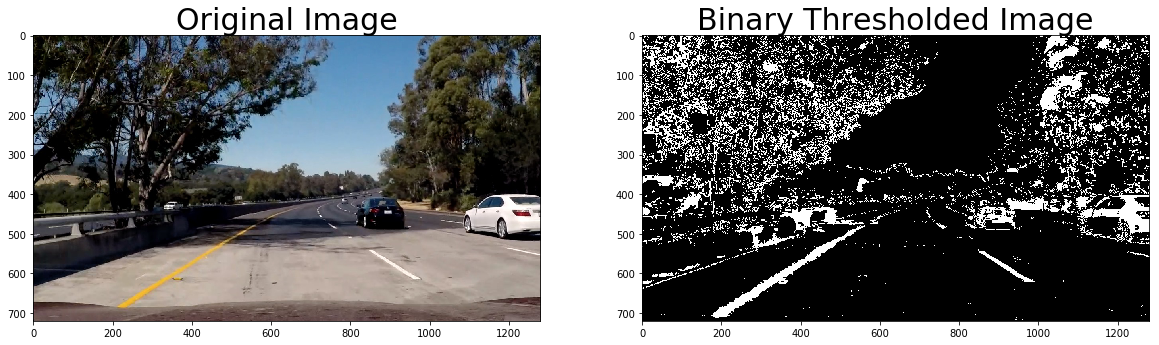

In [16]:
def combined_threshold(image):
    gradient_binary = gradient_threshold(image)
    color_binary = color_threshold(image)
    combined = np.zeros_like(gradient_binary)
    combined[(gradient_binary == 1) | (color_binary == 1)] = 1
    return combined

test_image = mpimg.imread('test_images/test5.jpg')
binary_output = combined_threshold(undistort(test_image))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Binary Thresholded Image', fontsize=30)

# Perspective Transform

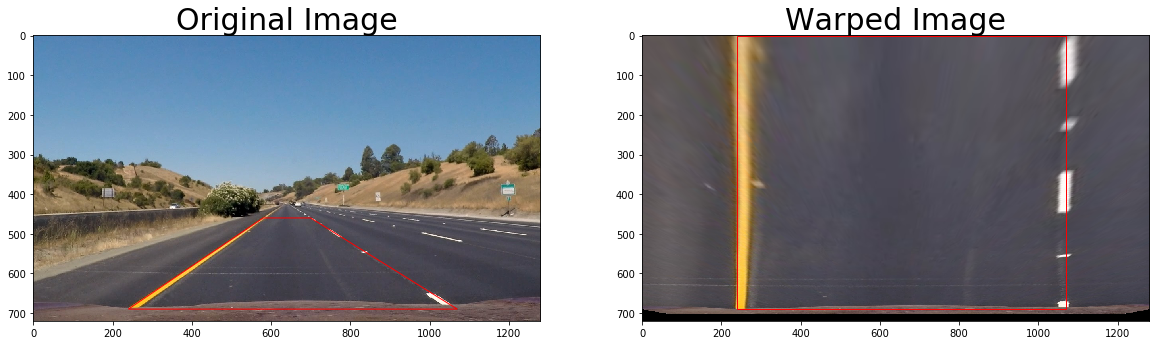

In [17]:
%matplotlib inline
import matplotlib.patches as patches

test_image = mpimg.imread('test_images/straight_lines1.jpg')

# clockwise
src_vertices = np.float32(
    [[700, 460],
     [1070, 690],
     [240, 690],
     [580, 460]])
dst_vertices = np.float32(
    [[1070, 0],
     [1070, 690],
     [240, 690],
     [240, 0]])

M = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
Minv = cv2.getPerspectiveTransform(dst_vertices, src_vertices)

def perspective_transform(image):
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

def inverse_perspective_transform(image):
    return cv2.warpPerspective(image, Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

warped = perspective_transform(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.add_patch(patches.Polygon(xy=src_vertices, fill=False, edgecolor='r'))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.add_patch(patches.Polygon(xy=dst_vertices, fill=False, edgecolor='r'))
ax2.set_title('Warped Image', fontsize=30)

# Finding Lane Lines

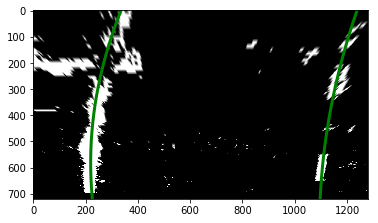

In [18]:
def poly_fit(binary_warped):
        
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

def poly_fit_with_heuristic(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # sometimes leftx can be an empty list
    # return None to fail sanity check
    if len(leftx) == 0 or len(rightx) == 0:
        return None, None, None, None, None, None
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, leftx, lefty, rightx, righty

test_image = mpimg.imread('test_images/test5.jpg')
binary = combined_threshold(undistort(test_image))
warped = perspective_transform(binary)
left_fit, right_fit, leftx, lefty, rightx, righty = poly_fit(warped)
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(warped, cmap='gray')
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)

# Measuring Curvature & Offset

In [19]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/870 # meters per pixel in x dimension

def measure_curvature(leftx, lefty, rightx, righty):
    # Fit new polynomials to x,y in world space
    y_eval = np.max(lefty)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

def measure_offset(left_fitx, right_fitx, image_length):
    return ((left_fitx[-1] + right_fitx[-1]) - image_length) / 2 * xm_per_pix

left_curverad, right_curverad = measure_curvature(leftx, lefty, rightx, righty)
offset = measure_offset(left_fitx, right_fitx, warped.shape[1])

print('Left radius: {:03.2f}m'.format(left_curverad))
print('Right radius: {:03.2f}m'.format(right_curverad))
print('Vehicle is {:03.2f}m {} of center'.format(abs(offset), 'left' if offset > 0 else 'right'))

Left radius: 595.48m
Right radius: 980.19m
Vehicle is 0.09m left of center


# Pipeline

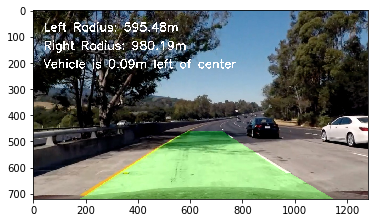

In [20]:
class Processor(object):

    def __init__(self):
        self.use_heuristic = False
        self.prev_params = None
        self.failed_cnt = 0

    def process_image(self, image):
        undist = undistort(image)
        binary = combined_threshold(undist)
        warped = perspective_transform(binary)

        # If three consecutive frame fail sanity check, do not use heuristic
        if self.failed_cnt > 3:
            self.use_heuristic == False
            self.failed_cnt = 0

        if self.use_heuristic == True:
            left_fit, right_fit, leftx, lefty, rightx, righty = self.prev_params
            left_fit, right_fit, leftx, lefty, rightx, righty = poly_fit_with_heuristic(warped, left_fit, right_fit)
        else:
            left_fit, right_fit, leftx, lefty, rightx, righty = poly_fit(warped)
            
        if self._pass_sanity_check(left_fit, right_fit, leftx, lefty, rightx, righty) == True:
            self.prev_params = (left_fit, right_fit, leftx, lefty, rightx, righty)
            self.use_heuristic = True
        elif self.prev_params is not None:
            self.failed_cnt += 1
            left_fit, right_fit, leftx, lefty, rightx, righty = self.prev_params
        else:
            self.failed_cnt += 1
            return undist

        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        left_curverad, right_curverad = measure_curvature(leftx, lefty, rightx, righty)
        offset = measure_offset(left_fitx, right_fitx, warped.shape[1])

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = inverse_perspective_transform(color_warp)
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        cv2.putText(result, "Left Radius: {:03.2f}m".format(left_curverad), (40, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 4)
        cv2.putText(result, "Right Radius: {:03.2f}m".format(right_curverad), (40, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 4)
        cv2.putText(result, "Vehicle is {:03.2f}m {} of center".format(abs(offset), 'left' if offset > 0 else 'right'), (40, 220), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 4)
        return result

    def _pass_sanity_check(self, left_fit, right_fit, leftx, lefty, rightx, righty):
        
        if left_fit is None or right_fit is None:
            return False
        # parallel checks
        if left_fit[0] * right_fit[0] < 0:
            return False
        elif left_fit[1] * right_fit[1] < 0:
            return False
        # distance check
        if rightx[0] - leftx[0] > 1000 or rightx[0] - leftx[0] < 750:
            return False
        return True

test_image = mpimg.imread('test_images/test5.jpg')
processor = Processor()
result = processor.process_image(test_image)
plt.imshow(result)

# Project Video

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'project_video_annotated.mp4'

video = VideoFileClip('project_video.mp4')
processor = Processor()
annotated_video = video.fl_image(processor.process_image)
%time annotated_video.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_annotated.mp4
[MoviePy] Writing video project_video_annotated.mp4


100%|█████████▉| 1260/1261 [03:47<00:00,  5.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_annotated.mp4 

CPU times: user 5min 13s, sys: 3.71 s, total: 5min 16s
Wall time: 3min 48s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

# Challenge Video

In [23]:
output_video = 'challenge_video_annotated.mp4'

video = VideoFileClip('challenge_video.mp4')
processor = Processor()
annotated_video = video.fl_image(processor.process_image)
%time annotated_video.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video challenge_video_annotated.mp4
[MoviePy] Writing video challenge_video_annotated.mp4


100%|██████████| 485/485 [01:21<00:00,  6.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_annotated.mp4 

CPU times: user 1min 54s, sys: 1.51 s, total: 1min 55s
Wall time: 1min 22s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

# Harder Challenge Video

In [25]:
output_video = 'harder_video_annotated.mp4'

video = VideoFileClip('harder_challenge_video.mp4')
processor = Processor()
annotated_video = video.fl_image(processor.process_image)
%time annotated_video.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video harder_video_annotated.mp4
[MoviePy] Writing video harder_video_annotated.mp4


100%|█████████▉| 1199/1200 [04:02<00:00,  4.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_video_annotated.mp4 

CPU times: user 5min 27s, sys: 2.78 s, total: 5min 30s
Wall time: 4min 3s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))